In [15]:
%matplotlib inline

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=200


In [16]:
# import the function we are trying to optimize
import pickle
gpr_model = pickle.load(open("gprMatern0.66.dump","rb"))
normalizer = lambda X: (X - [103.16726412, 103.05644853, 122.86389106] )/ [3.54492885, 3.87407133, 3.28592364]
func = lambda currents: gpr_model.predict(normalizer(currents.reshape(1, -1)))[0]
func(np.array([110,110,120]))

42.23986794972206

In [17]:
class Venus:
    def __init__(
        self,
        inj_limits=[97, 110],
        mid_limits=[97, 110],
        ext_limits=[116, 128],
        beam_range=[0.50, 1.00],
        jitter=0
    ):
        """The limits on the magnetic solenoids currents and the beam range (ouput).
        A random jitter can be added also (fraction of 1.)."""
        self.inj_limits = inj_limits
        self.mid_limits = mid_limits
        self.ext_limits = ext_limits
        self.beam_range = beam_range
        self.currents = np.zeros(3)
        self.jitter = jitter
        self.rng = np.random.default_rng(42)

    def set_mag_currents(self, inj, mid, ext):
        """Set the magnetic currents on the coils."""
        for v, lim in zip([inj, mid, ext], [self.inj_limits, self.mid_limits, self.ext_limits]):
            if v < lim[0] or v > lim[1]:
                raise ValueError("Setting outside limits")
        self.currents = np.array([inj, mid, ext])

    def _rescale_inputs(self, inputs):
        """input to himmelblau4 must be in [-6, 6]."""
        return (
            (c - l[0]) * 12.0 / (l[1] - l[0]) - 6.0
            for c, l in zip(inputs, [self.inj_limits, self.mid_limits, self.ext_limits])
        )

    def _rescale_output(self, output):
        """simple square returns values betwen 0 and 27 for w, x, y, z in [-6, 6]."""
        return (
            (1. - (output / 27.0) + self.rng.normal(0.0, self.jitter)) *
            (self.beam_range[1] - self.beam_range[0]) + self.beam_range[0]
        )
    
    def get_noise_level(self):
        # return std of the noise
        noise = self.jitter*(self.beam_range[1] - self.beam_range[0])
        return noise

    def get_beam_current(self):
        """Read the current value of the beam current"""
        return func(self.currents)

    @staticmethod
    def _simple_square(w, x, y):
        """A not so funky 3 dimensional parameter space with a single minima."""
        return (
            (w - 3.)**2 + (x - 3.)**2 + (y - 3.)**2
        )

create a venus object, defaults might be refined by values from Damon. For simpler algorithm the jitter can be set to 0 initially but it should work with a value larger than that in the end.

In [18]:
venus = Venus(jitter=0.15)

set the currents and read the beam value

In [19]:
venus.set_mag_currents(100, 100, 120)
bc = venus.get_beam_current()
print(bc)

99.8081477254076


if currents are outside the range a `ValueError` is raised and can be captured.

In [20]:
venus.set_mag_currents(50, 200, 200)

ValueError: Setting outside limits

# Bayesian Optimization

In [21]:
from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")

# Define the black box function to optimize.
def black_box_function(A, B, C):
    # C: SVC hyper parameter to optimize for.
    venus.set_mag_currents(A, B, C)
    v = venus.get_beam_current()
    return v

# Set range of C to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"A": [97, 110], "B": [97, 110], "C": [116, 128]}
# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2,
                                 random_state = 29)
optimizer.maximize(init_points = 5, n_iter = 20, kappa=2.3, alpha=0.15)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |     A     |     B     |     C     |
-------------------------------------------------------------
|  1        |  29.78    |  108.2    |  100.7    |  116.9    |
|  2        |  75.98    |  106.9    |  102.9    |  122.5    |
|  3        |  116.3    |  106.4    |  108.0    |  125.2    |
|  4        |  94.33    |  106.5    |  100.1    |  124.6    |
|  5        |  100.2    |  97.76    |  102.3    |  123.3    |
|  6        |  62.41    |  101.1    |  109.1    |  128.0    |
|  7        |  86.73    |  102.8    |  108.4    |  122.6    |
|  8        |  118.2    |  105.8    |  104.6    |  127.8    |
|  9        |  98.57    |  110.0    |  106.8    |  128.0    |
|  10       |  81.35    |  101.9    |  99.82    |  128.0    |
|  11       |  58.25    |  110.0    |  109.9    |  123.4    |
|  12       |  89.23    |  106.7    |  107.1    |  127.4    |
|  13       |  134.4    |  105.6    |  105.0    |  126.5    |
|  14       |  125.1    |  104.9    |  105.8    |  125.2    |
|  15   

In [31]:
import random
# try a certain times and see how many converges
CUTOFF = 140
def trial(N, n_iter = 15, init_points = 5, kappa = 3, verbose = 0, rand_adder = 0):
    # higher kappa prefers exploration
    # initial points are randomly chosen within bounds
    # rand_adder is to make sure we probe some different randstates in each trial
    # rand_adder = random.randint(1,1000)
    results = []
    coords = []
    pbounds = {"A": [97, 110], "B": [97, 110], "C": [116, 128]}
    noise = 0.15 # max(venus.get_noise_level(), 1e-5)
    print(noise)

    for i in tqdm(range(N)):
        # Create a BayesianOptimization optimizer,
        # and optimize the given black_box_function.
        optimizer = BayesianOptimization(f = black_box_function,
                                         pbounds = pbounds, verbose = 0)
                                         # random_state = i+rand_adder)
        optimizer.maximize(init_points = init_points, n_iter = n_iter, kappa=kappa, alpha=noise) # 
        if verbose>1:
            print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
        results.append(optimizer.max["target"])
        coords.append(optimizer.max["params"])
        del optimizer
    
    plt.title("n_iter = {}, init_points = {}, kappa = {}".format(n_iter, init_points, kappa))
    plt.hist(results)
    plt.show()
    
    plt.scatter([coords[i]['A'] for i in range(len(coords))], [coords[i]['B'] for i in range(len(coords))]) #, [coords[i]['C'] for i in range(len(coords))]
    plt.xlim(pbounds['A'][0], pbounds['A'][1])
    plt.ylim(pbounds['B'][0], pbounds['B'][1])
    # ax.set_zlim3d(pbounds['C'][0], pbounds['C'][1])
    
    plt.show()
    if verbose > 0:
        print(list(reversed(sorted(results))))   
def trial2(N, n_iter = 15, init_points = 5, kappa = 3, verbose = 0, rand_adder = 0):
    # higher kappa prefers exploration
    # initial points are randomly chosen within bounds
    # rand_adder is to make sure we probe some different randstates in each trial
    # rand_adder = random.randint(1,1000)
    results = []
    coords = []
    pbounds = {"A": [97, 110], "B": [97, 110], "C": [116, 128]}
    noise = max(venus.get_noise_level(), 1e-5)
    
    for i in tqdm(range(N)):
        # Create a BayesianOptimization optimizer,
        # and optimize the given black_box_function.
        optimizer = BayesianOptimization(f = black_box_function,
                                         pbounds = pbounds, verbose = 0)
                                         # random_state = i+rand_adder)
        optimizer.maximize(init_points = init_points, n_iter = n_iter, kappa=kappa, alpha=noise) # 
        if verbose>1:
            print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
        results.append(optimizer.max["target"])
        coords.append(optimizer.max["params"])
        del optimizer
    # print("Results:", results)
    n_succ = sum([i>=CUTOFF for i in results]) / len(results)
    return n_succ, results

# Fair coin problem
# prior is f(p) = 1 for p in range [0,1]  
# observation O is H positive in N trials  
# ask: what is the posterior f(p|O)
# f(p|O) = Pr(O|p) * f(p) / Pr(O) = Pr(O|p) * f(p) * const.
# f(p|O) ~ p^H * (1-p)^(N-H)
# var(p|O) = E((p|O)^2) - E(p|O)^2
#          = [continued in mathematica "Parameter Exploration - Theory and Simulation/FairCoinProb Posterior.nb"]
def FairCoinVar(H, N):
    return (1 - H**2 + N + H * N)/((2 + N)**2 * (3 + N))
FairCoinVar(10, 100) ** (1/2)

0.030563159973920874

In [23]:
trial2(10, n_iter = 10, init_points = 5, kappa = 2.3, verbose = 0)

100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


(0.3,
 [137.67657799559476,
  142.06922017611203,
  138.1942036509884,
  146.00257881589897,
  128.3669949995407,
  141.12610381900484,
  132.0072655336598,
  110.34123458857945,
  133.27694668293353,
  118.69560858502705])

In [40]:
REPEATS = 100
N_ITER = 40
succ_rates = []
results_list = []
kappas = np.linspace(0.1, 5, 10)
for kappa in kappas:
    succ_rate, results = trial2(REPEATS, n_iter = N_ITER, init_points = 3, kappa = kappa, verbose = 0)
    succ_rates.append(succ_rate)
    results_list.append(results)

100%|██████████| 100/100 [05:44<00:00,  3.45s/it]


In [44]:
np.savetxt("results%drepeat%diter.csv"%(REPEATS,N_ITER), np.array(results_list))
results_list = np.loadtxt("results%drepeat%diter.csv"%(REPEATS,N_ITER))
results_list.shape

(10, 100)

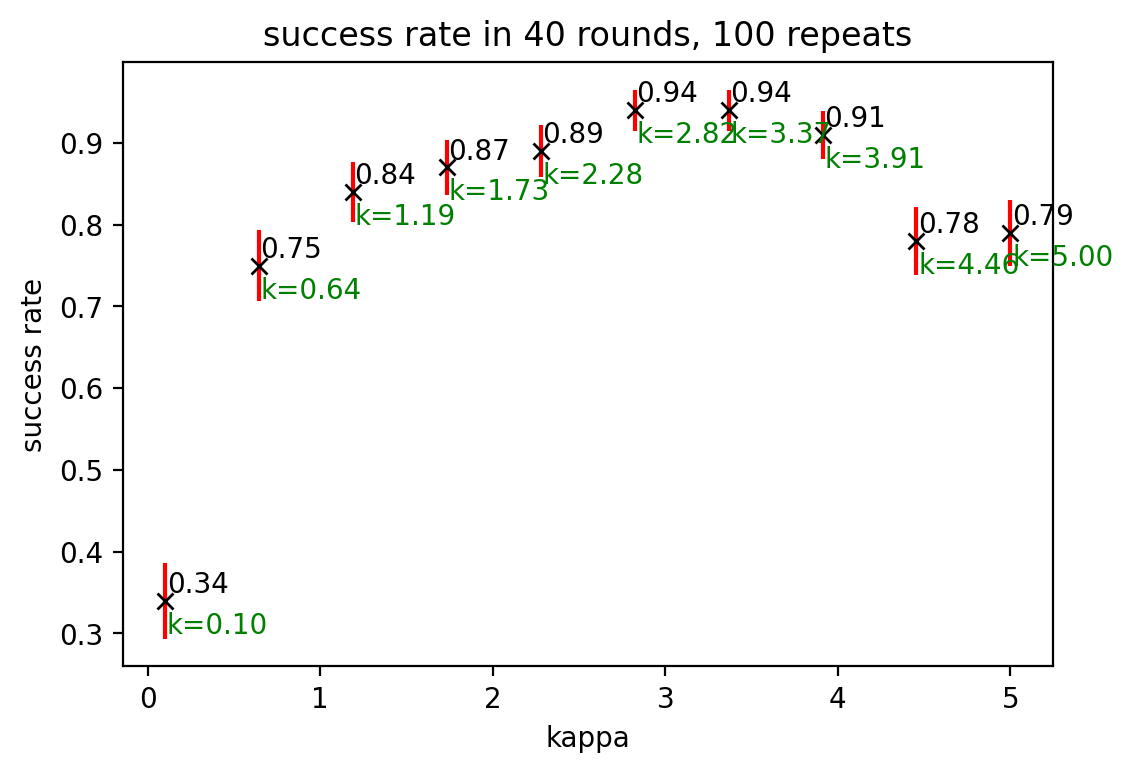

In [45]:
succ_rate_err = [FairCoinVar(rate*REPEATS, REPEATS) ** (1/2) for rate in succ_rates]
plt.errorbar(kappas, succ_rates, yerr=succ_rate_err, fmt="x", color='black', ecolor="red")
plt.xlabel("kappa")
plt.ylabel("success rate")
plt.title("success rate in 40 rounds, 100 repeats")
dist = kappas[2]-kappas[1]
for index, value in enumerate(succ_rates):
    x = kappas[index]
    plt.text(x+0.01, value+0.01, "%.2f"%value)
    plt.text(x+0.01, value-0.04, "k=%.2f"%x, color="green")
plt.savefig("succ_rate%drepeats%diters.png"%(REPEATS, N_ITER))
plt.show()

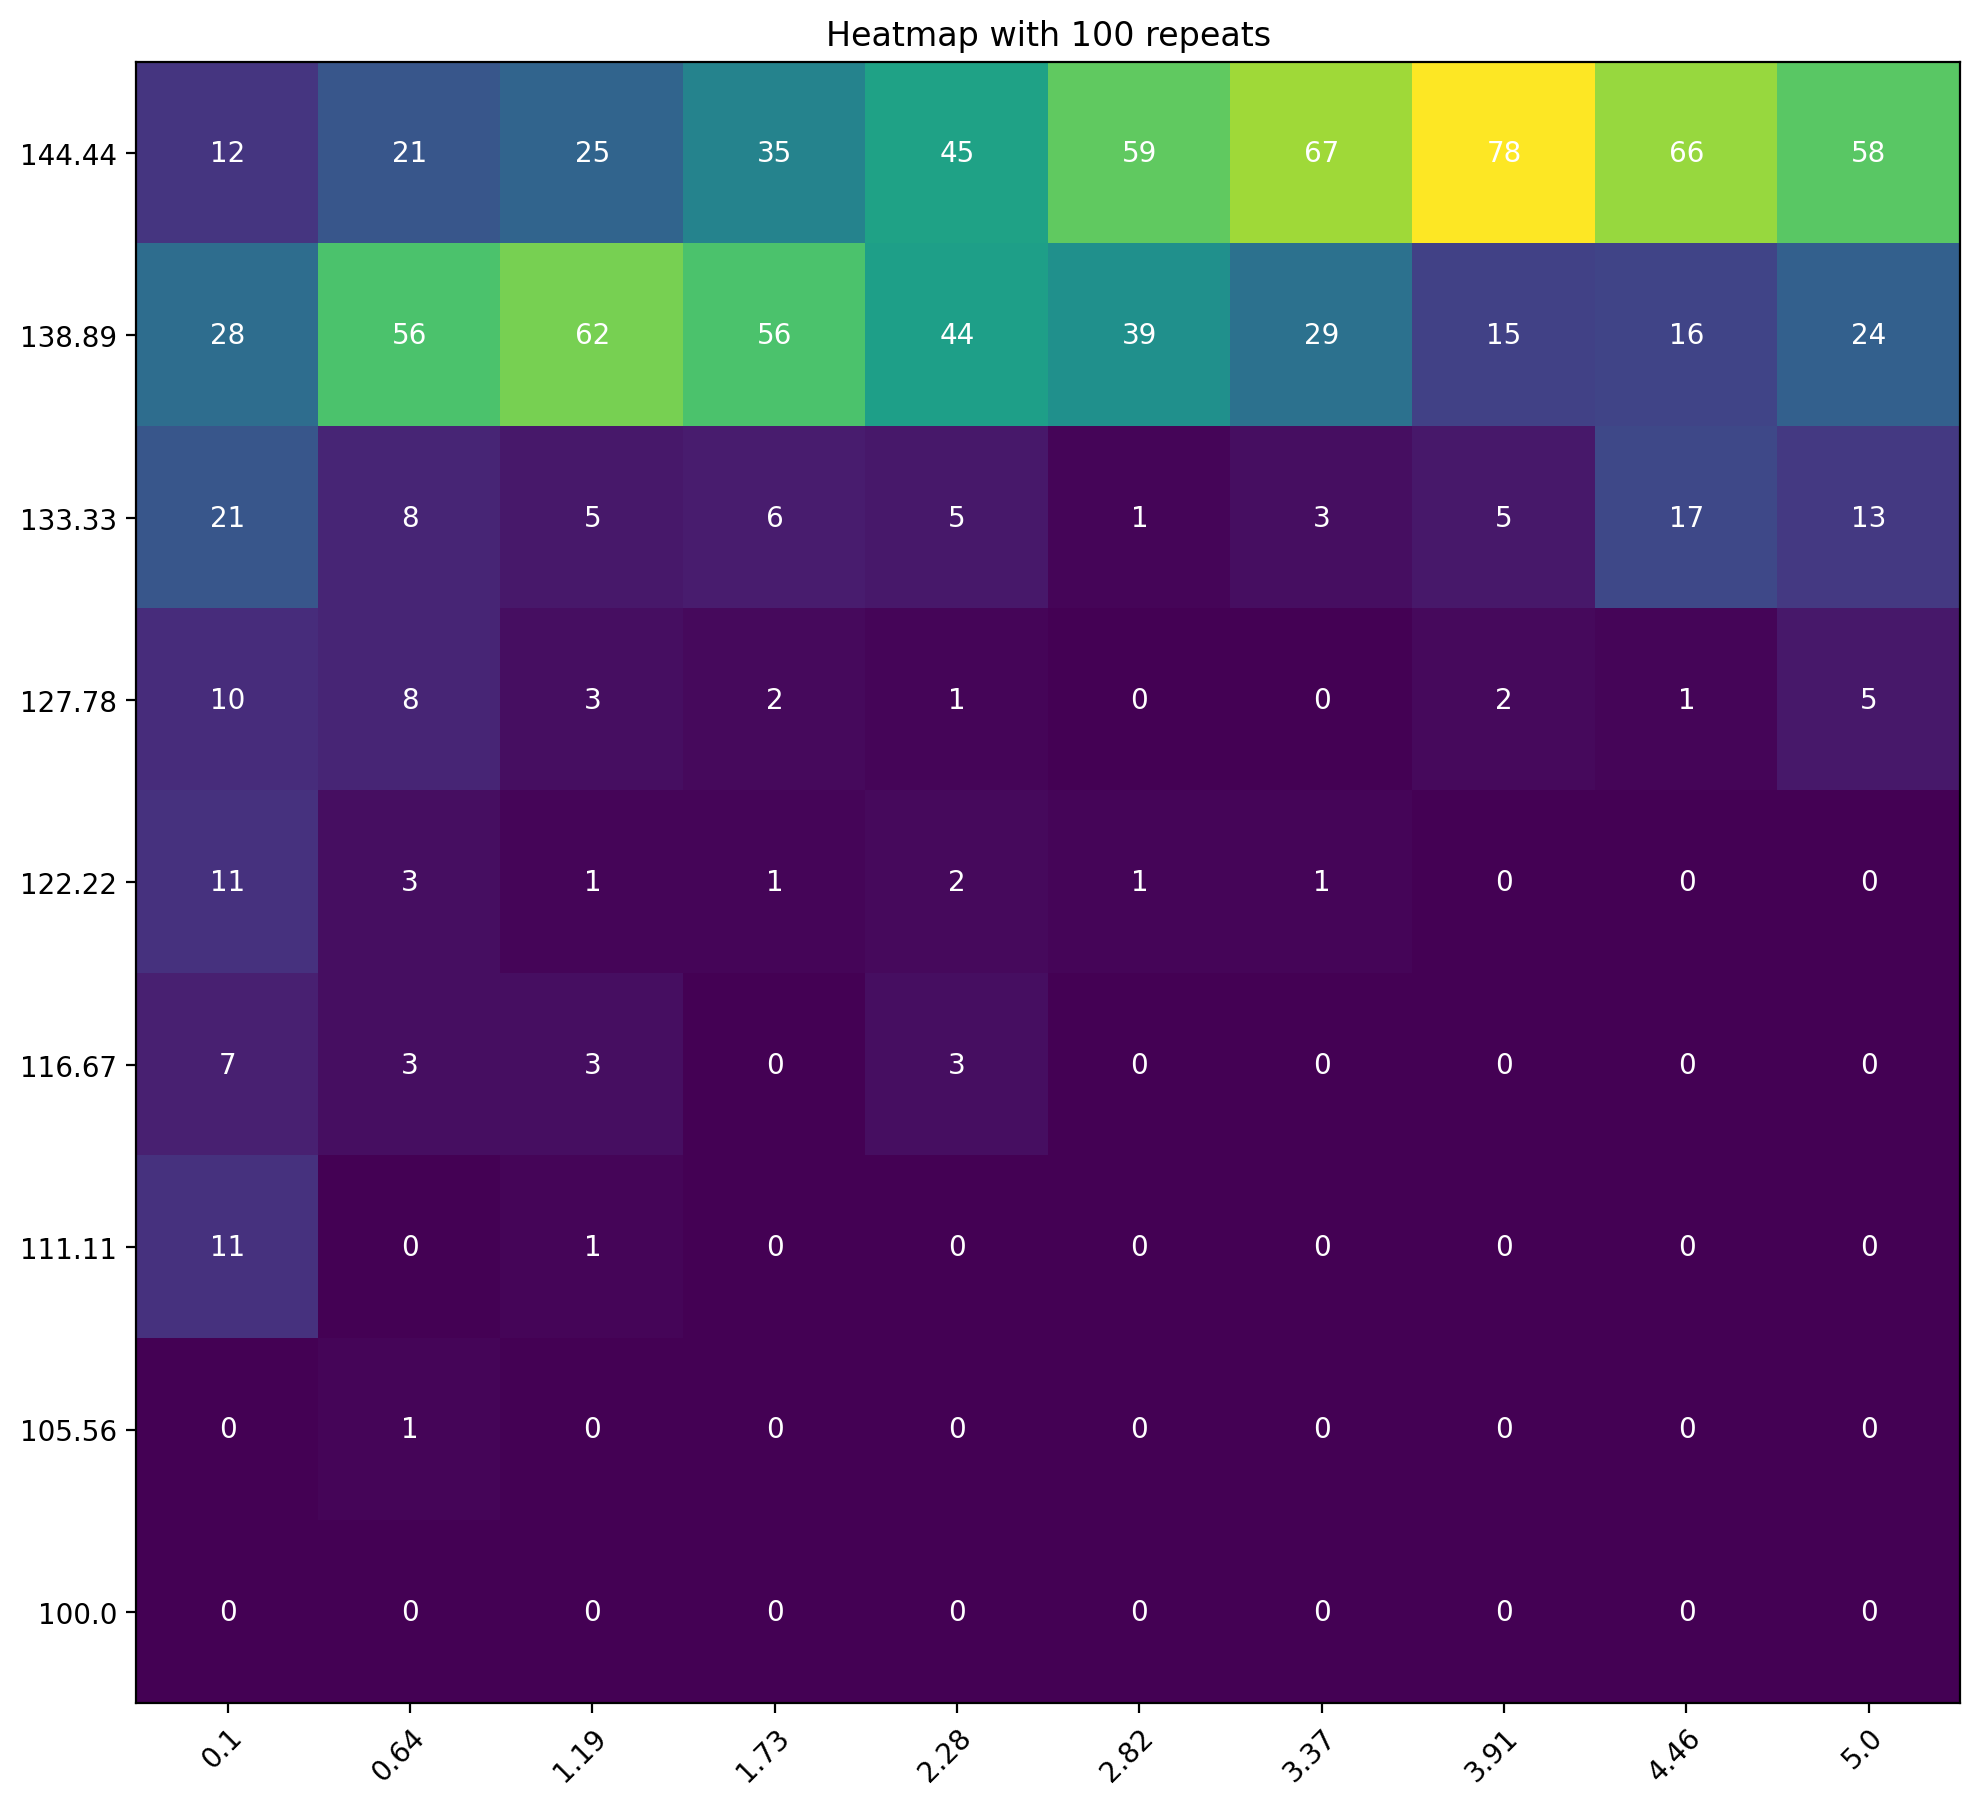

In [47]:
MIN = 100
MAX = 150
hist_bin = list(np.linspace(MIN, MAX, 10))
hist_list = []
for results in results_list:
    hist, bins = np.histogram(results, bins=hist_bin)
    hist_list.append(hist)
hist_results = np.vstack(hist_list).T[::-1]
hist_bin = [round(h,2) for h in hist_bin][:-1][::-1] # data manipulation for plots

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(hist_results)

# avg_list = [(sum(results)/len(results)-MIN)/(MAX-MIN) for results in results_list]
# ax.plot(avg_list, color="red")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(kappas)))
ax.set_xticklabels([round(k,2) for k in kappas])
ax.set_yticks(np.arange(len(hist_bin)))
ax.set_yticklabels(hist_bin)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(hist_bin)):
    for j in range(len(kappas)):
        text = ax.text(j, i, hist_results[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Heatmap with %d repeats"%REPEATS)
fig.tight_layout()
plt.savefig("Graphs/heatmap%drepeats%diters.png"%(REPEATS, N_ITER))
plt.show()

## Simple Trial

0.075


100%|██████████| 1/1 [00:03<00:00,  3.42s/it]

Best result: {'A': 102.06889102090035, 'B': 97.0, 'C': 125.84338618361845}; f(x) = 148.55273094936692.


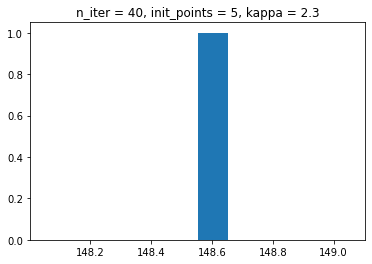

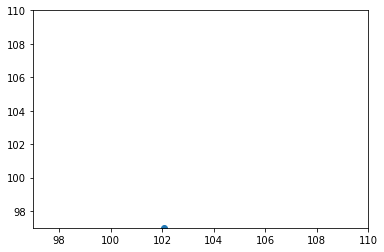

[148.55273094936692]


In [27]:
trial(1, n_iter = 40, init_points = 5, kappa = 2.3, verbose = 2)

## Making sure our method is better than random

0.15


100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


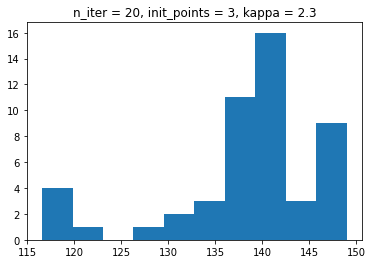

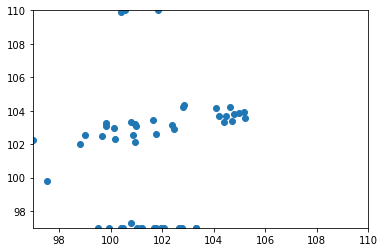

[148.94083564944438, 148.80293350364641, 148.7804308971855, 148.61935274479188, 148.5289763923368, 148.06598084149138, 147.3610279717895, 147.18976971171958, 146.12354362556522, 144.25024624162748, 144.16503568531775, 143.24215145174185, 142.11688556428263, 141.98421279567341, 141.95195399628514, 141.75233814055687, 141.7174072258657, 141.48947936664055, 141.4313743113626, 141.1477179354017, 140.93284751457222, 139.97523908717832, 139.8283615542519, 139.66094659998166, 139.559813644353, 139.51138930083158, 139.4664540436107, 139.4231859011972, 138.94542341598026, 138.9074443080565, 138.8313909321047, 138.41573296938373, 137.5484412884773, 137.17704228583517, 137.0977993685779, 137.0362716432221, 136.73680949978296, 136.3196606189075, 136.25613863503335, 134.8336208005396, 133.55256605120434, 133.32332391584293, 130.82741483238712, 130.45136029515473, 127.88148339534604, 122.8432345212318, 119.51880295288537, 119.51754923273327, 119.1022863528063, 116.58310008409707]


In [70]:
trial(50, n_iter = 20, init_points = 3, kappa = 2.3, verbose = 1)

0.15


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


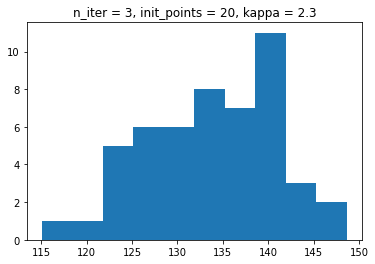

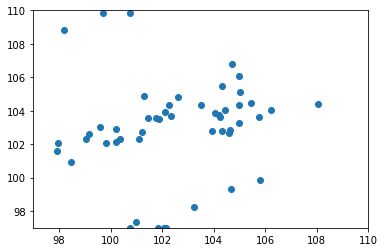

[148.60497691637062, 147.52605764966574, 143.732273991048, 142.60215145011867, 141.98159479291326, 141.71366977904802, 141.54859963840352, 141.11080600276279, 140.22492217340985, 140.18893667500285, 139.93188259992684, 139.52175289521378, 139.28884887333564, 139.13110441972145, 139.1045710218415, 138.7297493510525, 138.17503983630107, 138.065233726919, 138.05955279879643, 137.49961053169292, 137.20862789964204, 136.36644992189278, 135.33305042113108, 135.12793675987925, 134.2876222130726, 134.08161039952884, 133.99040448378582, 133.37358555525233, 132.91447823539238, 132.37739304666889, 132.0036048397521, 131.8356615123824, 131.31676482650772, 130.4700755409994, 130.23996218472954, 129.45132972319993, 128.9118316676865, 128.0993839529267, 126.92085663181928, 126.63022948419248, 126.6280477108036, 126.24890945709483, 125.38903932454623, 125.0258296095181, 124.16380024134672, 122.05308320945858, 121.97681730747395, 121.85899739558468, 120.6087233479306, 115.11346702958055]


In [71]:
# we see that more iteration is better than more initial points, meaning our sampling is more efficient than random sample
trial(50, n_iter = 3, init_points = 20, kappa = 2.3, verbose = 1)